# Hierarchical Clustering

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform

In [2]:
def plot_parallel_coordinates_clusters(df, cluster_centers):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(cluster_centers)):
        plt.plot(cluster_centers[i], marker='o', label='Cluster %s' % i)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.xticks(range(0, len(df.columns)), df.columns, fontsize=18)
    plt.legend(fontsize=10)
    plt.show()

In [3]:
def plot_radar_clusters(df, cluster_centers):
    # number of variable
    N = len(df.columns)
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    for i in range(0, len(cluster_centers)):
        angles = [n / float(N) * 2 * pi for n in range(N)]
        values = cluster_centers[i].tolist()
        values += values[:1]
        angles += angles[:1]
        # Initialise the spider plot
        ax = plt.subplot(polar=True)
        # Draw one axe per variable + add labels labels yet
        plt.xticks(angles[:-1], df.columns, color='grey', size=8) 
        # Plot data
        ax.plot(angles, values, linewidth=1, linestyle='solid')
        # Fill area
        ax.fill(angles, values, 'b', alpha=0.1)

In [4]:
def plot_date_feature_clusters(df, labels, num_cluster):

    for i in range(num_cluster):
        i_samples = labels==i
        df_cat[i_samples].name.groupby(pd.to_datetime(df_cat.loc[i_samples, 'created_at'], format='%Y-%m-%d %H:%M:%S', errors='raise').dt.year).count().plot(kind="bar")
        plt.show()

In [5]:
def categorical_hist_clusters(df, labels, feature_name):
    bot_xt_pct = pd.crosstab(labels, df[feature_name])
    bot_xt_pct.plot(kind='bar', stacked=False, 
                       title=f'{feature_name} per cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature_name)
    plt.show()

In [6]:
def plot_numerical_features_clusters(df, labels, num_cluster):
    """
    print and plot distribution of numerical features conditioned by the cluster
    """
    
    for i in range(num_cluster):
        i_samples = labels==i
        df[i_samples].boxplot()
        df[i_samples].hist()
        plt.show()

In [7]:
def scatter_features_clusters(df, labels):
    for i in range(len(df.columns)):
        for j in range(i+1, len(df.columns)):
            feature_1 = df.columns[i]
            feature_2 = df.columns[j]
            
            print(f"{feature_1} - {feature_2}")
            plt.scatter(df[feature_1], df[feature_2], c=labels, s=20)
            plt.tick_params(axis='both', which='major', labelsize=22)
            plt.show()

In [8]:
df = pd.read_csv("dataset/user_profiles.csv", skipinitialspace=True, sep=',')

In [9]:
df.head()

,Unnamed: 0,name,lang,bot,created_at,statuses_count,avg_length,avg_special_chars,urls_ratio,mentions_ratio,hashtags_ratio,reply_count_mean,reply_count_std,reply_count_entropy,favorite_count_mean,favorite_count_std,favorite_count_entropy,retweet_count_mean,retweet_count_std,retweet_count_entropy
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,62.340909,14.015152,0.000000,0.272727,0.098485,0.0,0.0,0.0,0.037879,0.190903,1.609438,0.037879,0.190903,1.609438
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,4,69.082645,15.041322,0.000000,0.338843,0.024793,0.0,0.0,0.0,0.049587,0.217090,1.791759,0.024793,0.155495,1.098612
2,137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,7,19.250000,5.250000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50,86.944871,18.689463,0.022331,0.006281,0.072575,0.0,0.0,0.0,0.165387,0.530838,5.105129,0.826239,13.034008,2.170410
4,2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,8,72.311246,14.582073,0.000825,0.506461,0.118229,0.0,0.0,0.0,0.056365,0.243387,5.248623,0.016772,0.142619,3.965939


In [10]:
cat_feature = df[['name','lang','created_at', 'bot']]
del df['name']
del df['lang']
del df['created_at']
del df['bot']
df.head()

,Unnamed: 0,statuses_count,avg_length,avg_special_chars,urls_ratio,mentions_ratio,hashtags_ratio,reply_count_mean,reply_count_std,reply_count_entropy,favorite_count_mean,favorite_count_std,favorite_count_entropy,retweet_count_mean,retweet_count_std,retweet_count_entropy
0,2353593986,76,62.340909,14.015152,0.000000,0.272727,0.098485,0.0,0.0,0.0,0.037879,0.190903,1.609438,0.037879,0.190903,1.609438
1,2358850842,4,69.082645,15.041322,0.000000,0.338843,0.024793,0.0,0.0,0.0,0.049587,0.217090,1.791759,0.024793,0.155495,1.098612
2,137959629,7,19.250000,5.250000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,466124818,50,86.944871,18.689463,0.022331,0.006281,0.072575,0.0,0.0,0.0,0.165387,0.530838,5.105129,0.826239,13.034008,2.170410
4,2571493866,8,72.311246,14.582073,0.000825,0.506461,0.118229,0.0,0.0,0.0,0.056365,0.243387,5.248623,0.016772,0.142619,3.965939


In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [12]:
scaler = StandardScaler()
scaler.fit(df.values)
scaler = MinMaxScaler()
X = scaler.fit_transform(df.values)

In [13]:
X[:5]

array([[7.43590320e-01, 2.61168385e-01, 2.45210368e-01, 9.40614196e-02,
        0.00000000e+00, 4.71428571e-02, 1.73695406e-02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.19347335e-03, 1.07580675e-02,
        1.96561534e-01, 8.99733679e-05, 9.61915876e-04, 2.00483890e-01],
       [7.45251641e-01, 1.37457045e-02, 2.73068779e-01, 1.00948472e-01,
        0.00000000e+00, 5.85714286e-02, 4.37275149e-03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.56236512e-03, 1.22337755e-02,
        2.18828566e-01, 5.88916590e-05, 7.83502563e-04, 1.36851545e-01],
       [4.33850031e-02, 2.40549828e-02, 6.71487603e-02, 3.52348993e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.47094810e-01, 1.71821306e-01, 3.46879632e-01, 1.25432635e-01,
        1.11653873e-02, 1.08563453e-03, 1.27998848e-02, 0.000

In [14]:
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

##### Cosine similarity

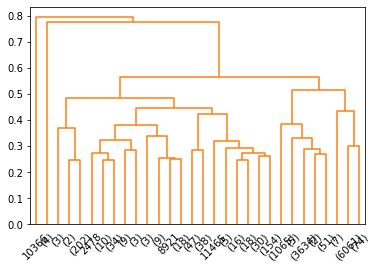

In [15]:
data_dist = pdist(X, metric='cosine') #computes the similarity matrix using cosine similarity
data_link = linkage(data_dist, method='average', metric='cosine') #performs hierarchical clustering
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
#res = dendrogram(data_link, p=5, color_threshold=1.0, truncate_mode='level')

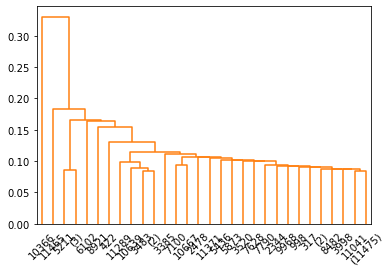

In [16]:
data_dist = pdist(X, metric='cosine') #computes the similarity matrix using cosine similarity
data_link = linkage(data_dist, method='single', metric='cosine') #performs hierarchical clustering
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

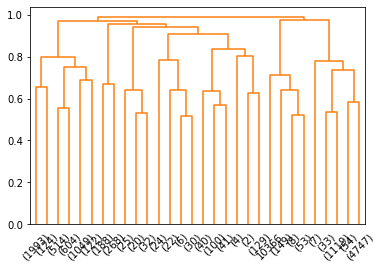

In [17]:
data_dist = pdist(X, metric='cosine') #computes the similarity matrix using cosine similarity
data_link = linkage(data_dist, method='complete', metric='cosine') #performs hierarchical clustering
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

##### Euclidean distance

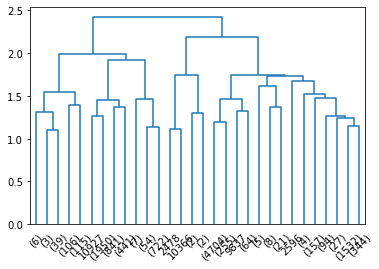

In [18]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

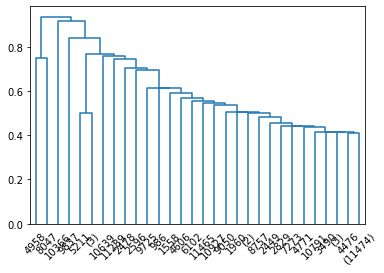

In [19]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='single', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.2, truncate_mode='lastp')

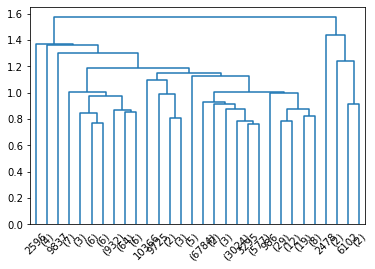

In [20]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='average', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.4, truncate_mode='lastp')

In [21]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
cluster.fit_predict(X)

array([3, 3, 1, ..., 1, 3, 0], dtype=int64)

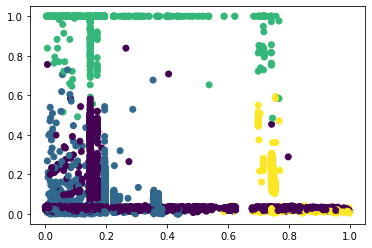

In [22]:
plt.scatter(X[:,0],X[:,1], c=cluster.labels_)

### Plot Cluster Results

# dbscan

In [23]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [24]:
dbscan = DBSCAN(eps=0.12, min_samples=7)
dbscan.fit(X)

DBSCAN(eps=0.12, min_samples=7)

In [25]:
dbscan.labels_[:5]

array([ 0,  0,  1,  2, -1], dtype=int64)

In [26]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9], dtype=int64),
 array([1886, 3381, 2796, 2914,   43,  390,   55,   11,    8,   17,    7],
       dtype=int64))

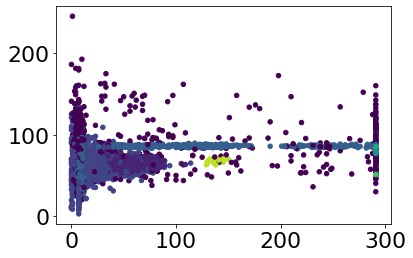

In [27]:
plt.scatter(df['statuses_count'], df['avg_length'], c=dbscan.labels_, s=20)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

In [28]:
print('Silhouette %s' % silhouette_score(X, dbscan.labels_))

Silhouette 0.21276067691804373


In [29]:
dist = pdist(X, 'euclidean') #pair wise distance
print (dist)
dist = squareform(dist) #distance matrix given the vector dist
print()
print(dist)

[0.25863302 0.81433974 0.75439032 ... 0.86902664 1.15701941 0.89786183]

[[0.         0.25863302 0.81433974 ... 0.86838974 0.13366844 0.95711405]
 [0.25863302 0.         0.780808   ... 0.82371521 0.15984343 0.95686777]
 [0.81433974 0.780808   0.         ... 0.40422404 0.8188535  1.11974589]
 ...
 [0.86838974 0.82371521 0.40422404 ... 0.         0.86902664 1.15701941]
 [0.13366844 0.15984343 0.8188535  ... 0.86902664 0.         0.89786183]
 [0.95711405 0.95686777 1.11974589 ... 1.15701941 0.89786183 0.        ]]


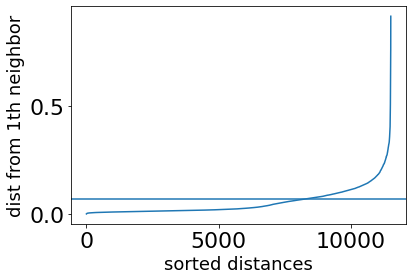

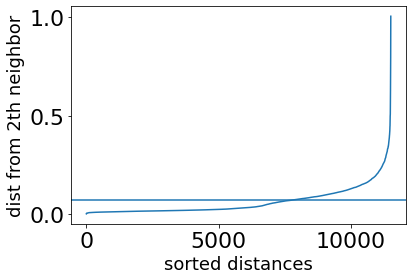

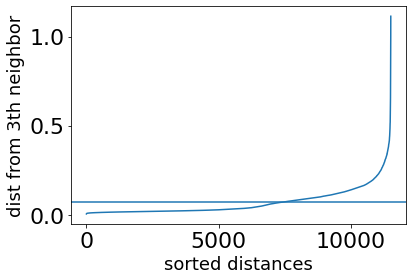

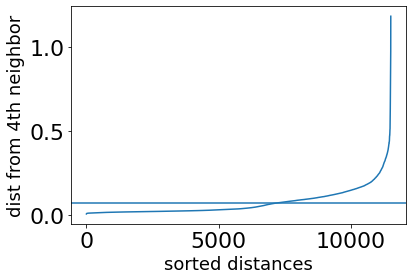

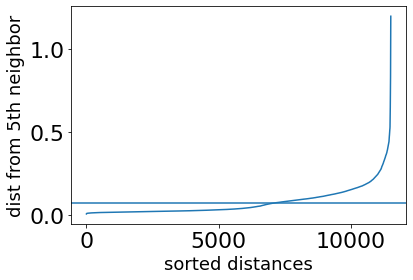

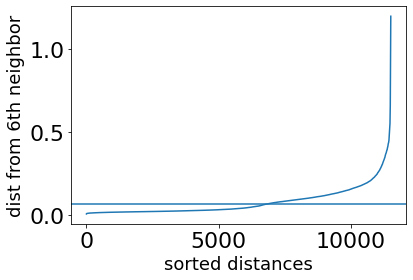

In [ ]:
for k in range (1, 10):
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])
    plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
    plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
    plt.xlabel('sorted distances', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=22)
    plt.axhline(y=0.07)
    plt.show()

### Plot Cluster Results